In [1]:
# test the segmenation of fMRI data vs. embeddings and linear integrator

In [2]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

In [3]:
import warnings
import sys 
import os    
import scipy.io

In [4]:
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp

Using Numpy backend.


In [5]:
#reservoir setup

vectorDim = 100
numNode = 1000
reps = 16
SherlockInputData = np.load('sherlock-input-data.npy')
in_small = np.load('CH2020_50/in_small.npy')
out_small = np.load('CH2020_50/out_small.npy')

In [6]:
segno=40  # k, or the number of segments we look for

fmri_bounds = np.zeros((17,segno-1))
reservoir_bounds = np.zeros((17,segno-1))


In [29]:
#run the linear integrator
inputDataTesting=np.load("sherlock-input-data.npy")
vectorDim=100
embedding_averages = np.empty((len(inputDataTesting),vectorDim))
integrator_averages = np.empty((len(inputDataTesting),vectorDim))
reservoir_averages = np.empty((len(inputDataTesting),vectorDim))


print(embedding_averages.shape)

for num in range(len(inputDataTesting)):
        if num == 0:
            embedding_averages[num] = inputDataTesting[num]
            integrator_averages[num] = inputDataTesting[num]
        else:
            #inputAverageTesting[num] = ((num * inputAverageTesting[num-1]) + inputDataTesting[num]) / (num + 1)
            integrator_averages[num] = .95*num * embedding_averages[num-1] + 1.05*inputDataTesting[num]
            embedding_averages[num] = inputDataTesting[num]

(1251, 100)


In [30]:
reservoir_averages = np.load('Exp2-sherlock-res-40.npy')
fmri_averages = np.load('Exp2-sherlock-fmri-40.npy')

In [31]:
ev_fmri = brainiak.eventseg.event.EventSegment(segno)
ev_fmri.fit(fmri_averages)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]),
             n_events=40)

In [35]:
# here we test reservoir embeddings, or linear integrator
ev_reservoir = brainiak.eventseg.event.EventSegment(segno)
ev_reservoir.fit(embedding_averages)  

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]),
             n_events=40)

In [26]:
for j in range(reservoir_averages.shape[1]):
    mean = reservoir_averages[:,j].mean()
    if abs(mean) > 0.0005:
        reservoir_averages[:,j] = reservoir_averages[:,j]/mean      

In [12]:
for j in range(fmri_averages.shape[1]):
    mean = fmri_averages[:,j].mean()
    if abs(mean) > 0.01:
        fmri_averages[:,j] = fmri_averages[:,j]/mean      

fMRI bounds  [ 38  55  85  97 110 134 156 171 194 229 255 266 306 337 363 381 398 425
 444 466 495 509 545 565 586 617 639 659 702 716 735 758 781 795 835 859
 876 892 924]
Reservoir bounds  [  29   74   97  131  156  180  206  233  267  295  322  350  392  443
  468  496  517  546  594  630  665  696  725  758  785  808  839  869
  906  951  981 1007 1040 1067 1105 1137 1159 1188 1226]
reps 16


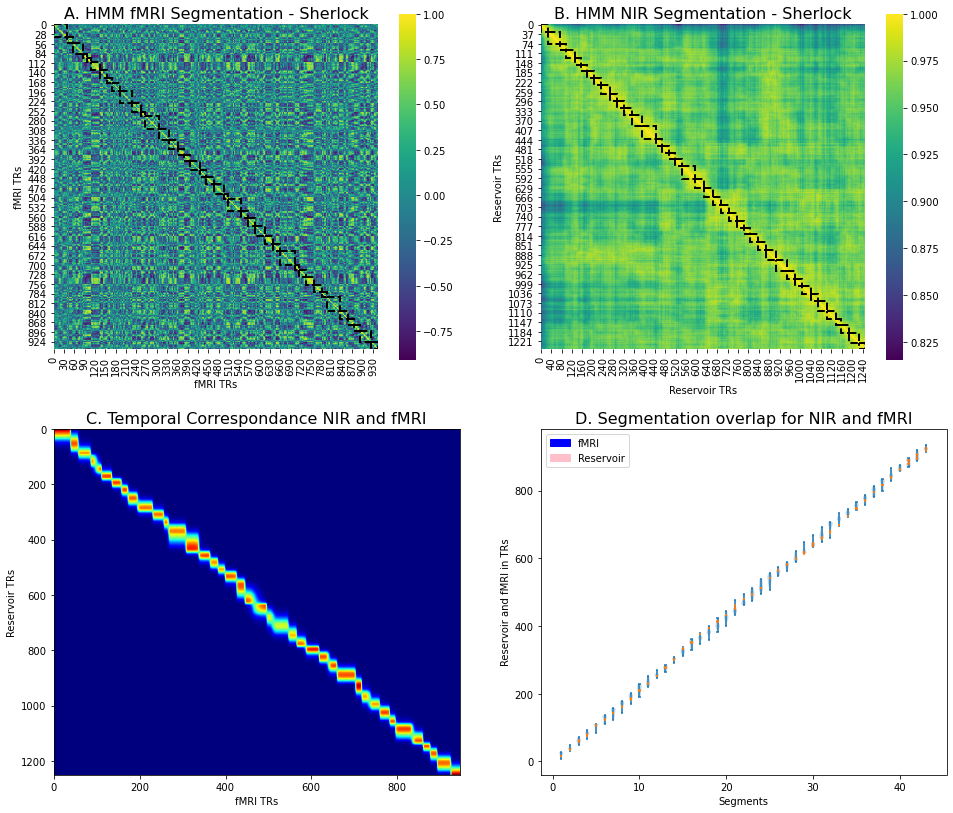

In [36]:
plt.figure(figsize=(16,14))
plt.subplot(2,2,1)
color='jet'
edge='black'
scale1=0.5
scale2=0.9
nTR=946

#plt.imshow(np.corrcoef(fmri_averages), cmap=color, vmin = scale1, origin = 'lower')
#plt.imshow(np.corrcoef(BOLD.mean(2).T))

sns.heatmap(np.corrcoef(fmri_averages),cmap='viridis', square=True)


bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
print('fMRI bounds ', bounds)
plt.xlabel('fMRI TRs')
plt.ylabel('fMRI TRs')

plt.title('A. HMM fMRI Segmentation - Sherlock', fontsize = 16)


plt.subplot(2,2,2)

sns.heatmap(np.corrcoef(reservoir_averages),cmap='viridis', square=True)


nTR=1251
bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)

print('Reservoir bounds ', bounds)    
plt.xlabel('Reservoir TRs')
plt.ylabel('Reservoir TRs')

plt.title('B. HMM NIR Segmentation - Sherlock', fontsize = 16)


plt.subplot(2,2,3)

plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')


plt.xlabel('fMRI TRs')
plt.ylabel('Reservoir TRs')

plt.title('C. Temporal Correspondance NIR and fMRI', fontsize = 16)



plt.subplot(2,2,4)
print('reps',reps)
#plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')#origin='lower',
plt.violinplot(fmri_bounds[:reps])
plt.violinplot(reservoir_bounds[:reps]/1251*946)

plt.xlabel('Segments')
plt.ylabel('Reservoir and fMRI in TRs')

red_patch = patches.Patch(color='pink', label='Reservoir')
#plt.legend(handles=[red_patch], loc='upper left')

blue_patch = patches.Patch(color='blue', label='fMRI')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

plt.title('D. Segmentation overlap for NIR and fMRI', fontsize = 16)




#fig.tight_layout()
plt.savefig('Exp2-replication-sherlock40.png', dpi=600)


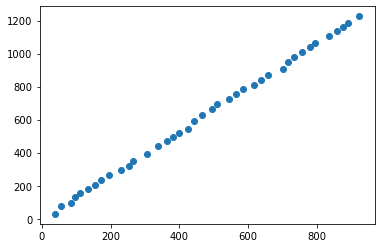

In [14]:
x = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]
y = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
plt.scatter(x,y)

In [15]:
reservoir_bounds = np.load('Exp2-sherlock-res-bounds-40.npy')
fmri_bounds= np.load('Exp2-sherlock-fmri-bounds-40.npy')

fmri_bounds_means= np.zeros(segno-1)
reservoir_bounds_means= np.zeros(segno-1)


for i in range(segno-1):
    fmri_bounds_means[i] = fmri_bounds[:reps,i].mean()
    reservoir_bounds_means[i] =reservoir_bounds[:reps,i].mean()

In [16]:
print(fmri_bounds.shape)

(17, 39)


In [17]:
#substitute embedding bounds after segmenting the embeddings or linear integrator
#reservoir_bounds_means = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]


p = 0.10464378994285689
[0.28205128 0.20512821 0.1025641  ... 0.41025641 0.33333333 0.20512821]


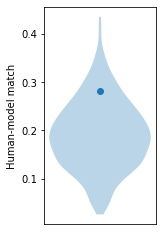

In [37]:
#reservoir_bounds = np.load('Exp2-sherlock-res-bounds.npy')
#fmri_bounds= np.load('Exp2-sherlock-fmri-bounds.npy')
#np.random.seed(1)
#bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]

#h_bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
#h_bounds = h_bounds/1251*1976
#h_bounds = h_bounds/1251*946

h_bounds = fmri_bounds_means
#bounds = reservoir_bounds_means/1251*946
bounds = bounds/1251*946

np.random.seed(2)

event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
nPerm = 1000
perm_bounds = bounds
threshold = 3

match = np.zeros(nPerm+1)
for p in range(nPerm+1):
    for hb in h_bounds:
        # check if match 
        if np.any(np.abs(perm_bounds - hb) <= threshold):
            match[p] += 1
    match[p] /= len(h_bounds)
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))
print(match)

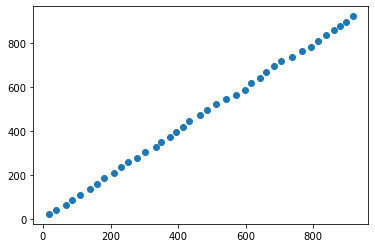

In [19]:
plt.scatter(bounds,h_bounds)

In [20]:
#fmri_bounds
#reservoir_bounds/682*400
i=0
for i in range(10):
    correlation, p_value = stats.pearsonr(fmri_bounds[i], reservoir_bounds[i])
    print('correltion: ',correlation)
    print('p_value: ', p_value)


correltion:  0.9994427549222964
p_value:  3.0465357351409188e-56
correltion:  0.9991894935528236
p_value:  3.111947367659816e-53
correltion:  0.9996398155159403
p_value:  9.514235976948721e-60
correltion:  0.9994211279952553
p_value:  6.160982092719273e-56
correltion:  0.9988498211165757
p_value:  2.0135947017249695e-50
correltion:  0.9989560109861897
p_value:  3.3579177108847744e-51
correltion:  0.9993446806180298
p_value:  6.109109157097197e-55
correltion:  0.9994578069631499
p_value:  1.8359164425202105e-56
correltion:  0.999036878050285
p_value:  7.561200221263022e-52
correltion:  0.9995813681915725
p_value:  1.535842914420601e-58


In [21]:
reservoir_averages=np.load('Exp2-sherlock-res.npy')
fmri_averages=np.load('Exp2-sherlock-fmri.npy')

In [22]:
reservoir_bounds = np.load('Exp2-sherlock-res-bounds.npy')
fmri_bounds= np.load('Exp2-sherlock-fmri-bounds.npy')

In [23]:
# get the mean bounds

print(reservoir_bounds.shape)
print(reservoir_bounds[:16,3])
print(reps)


(17, 43)
[105. 106. 105. 105. 105. 101. 107. 104. 107. 106. 104. 106. 105. 105.
 104. 105.]
16
